# Import & Setting

### Import

In [2]:
import os

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from sklearn.preprocessing import LabelEncoder

import torch
from torchvision import transforms
from PIL import Image
import pytorch_forecasting as pf

from datasets import load_dataset
from transformers import AutoImageProcessor, SwinModel
import timm

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setting

In [3]:
# Params for sampling 
num_samples = None

# Params for Train_test_split 
train_test_split_rto = 0.3

# Dataset
window_size = 100
predict_length = 7
batch_size = 64

# Model
d_model = 128
dropout = 0.3
nhead = 4
num_layers = 4
d_ff = 512

# Preprocess Data

### Read data

In [4]:
df_raw = pd.read_csv("HnM/transactions_train.csv", dtype={"article_id":str})
df_raw["img_path"] = df_raw["article_id"].apply(lambda x: f'./HnM/images/{x[:3]}/{x}.jpg')
df_raw["is_valid"] = df_raw["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0)
df_raw.head()

,t_dat,customer_id,article_id,price,sales_channel_id,img_path,is_valid
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,./HnM/images/066/0663713001.jpg,1
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,./HnM/images/054/0541518023.jpg,1
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,./HnM/images/050/0505221004.jpg,1
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,./HnM/images/068/0685687003.jpg,1
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,./HnM/images/068/0685687004.jpg,1


In [31]:
# More than quantile 0.7
print(df_raw["article_id"].nunique())
q_valid_prod = df_raw.groupby(["article_id", "t_dat"], as_index=False).size()
# q_valid_prod["cnt"] = q_valid_prod.groupby(["article_id"])["t_dat"].transform("count")

# q_valid_prod["min_val"] = q_valid_prod.groupby("article_id")["cnt"].transform("min")
# q_valid_prod["max_val"] = q_valid_prod.groupby("article_id")["cnt"].transform("max")
# q_valid_prod["3Q"] = q_valid_prod.groupby("article_id")["cnt"].transform(lambda x: np.quantile(x, 0.7))
# q_valid_prod[q_valid_prod["3Q"] > 10]

# q_valid_prod = q_valid_prod["article_id"]
# print(len(q_valid_prod))
display(q_valid_prod)

104547


,article_id,t_dat,size
0,0108775015,2018-09-20,30
1,0108775015,2018-09-21,48
2,0108775015,2018-09-22,11
3,0108775015,2018-09-23,26
4,0108775015,2018-09-24,33
...,...,...,...
7443540,0956217002,2020-09-15,1
7443541,0956217002,2020-09-16,1
7443542,0956217002,2020-09-18,3
7443543,0956217002,2020-09-20,1


### Sample data

In [6]:
# Get valid data only
df_sample = df_raw[
    (df_raw["is_valid"] == 1)
    &(df_raw["article_id"].isin(q_valid_prod))
    ]

# Get sample articld_id
num_samples = num_samples if num_samples else df_sample["article_id"].nunique()
sample_id_li = df_sample.groupby(["article_id", "t_dat"], as_index=False).agg(_=("price", "count")) # Get uinque dates per each article
sample_id_li = sample_id_li.groupby("article_id").size().sort_values(ascending=False)[:num_samples].index

# Sample
df_sample = df_sample[df_sample["article_id"].isin(sample_id_li)].reset_index(drop=True)
df_sample.head()

,t_dat,customer_id,article_id,price,sales_channel_id,img_path,is_valid
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,./HnM/images/066/0663713001.jpg,1
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,./HnM/images/054/0541518023.jpg,1
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2,./HnM/images/050/0505221004.jpg,1
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2,./HnM/images/068/0685687003.jpg,1
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2,./HnM/images/068/0685687004.jpg,1


### Preprocess

In [7]:
# To datetime
df_prep = df_sample.copy()
df_prep["t_dat"] = pd.to_datetime(df_prep["t_dat"])

# Preprocess
### Explode dates
def func(x):
    full_date = pd.DataFrame(pd.date_range(x["t_dat"].min(), x["t_dat"].max(), freq="d"), columns=["t_dat"])
    x = x.merge(full_date, on="t_dat", how="right").reset_index(drop=True)
    x["article_id"] = x["article_id"].unique()[0]
    x["sales"] = x["sales"].fillna(0)
    return x

df_prep = df_prep.groupby(["article_id", "t_dat"], as_index=False).agg(sales=("price", "count"))
df_prep = df_prep.groupby("article_id", as_index=False).apply(lambda x: func(x)).reset_index(drop=True)
df_prep["time_idx"] = df_prep.groupby("article_id").cumcount()

### LabelEncode image path
imgpath_encoder = LabelEncoder()
df_prep["img_path"] = df_prep["article_id"].apply(lambda x: f'HnM/images/{x[:3]}/{x}.jpg')
df_prep["img_path"] = imgpath_encoder.fit_transform(df_prep["img_path"])

# Train test split
num_train = int(np.round(num_samples * train_test_split_rto))
sample_id_li_train = sample_id_li[:num_train]

df_train = df_prep[df_prep["article_id"].isin(sample_id_li_train)].reset_index(drop=True)
df_valid = df_prep[~df_prep["article_id"].isin(sample_id_li_train)].reset_index(drop=True)
assert df_train.shape[0] + df_valid.shape[0] == df_prep.shape[0]

In [18]:
temp = df_prep.copy()
temp["min_val"] = temp.groupby("article_id")["sales"].transform("min")
temp["max_val"] = temp.groupby("article_id")["sales"].transform("max")
temp["3Q"] = temp.groupby("article_id")["sales"].transform(lambda x: np.quantile(x, 0.7))
temp[temp["3Q"] > 10]

,article_id,t_dat,sales,time_idx,img_path,min_val,max_val,3Q
0,0108775015,2018-09-20,30.0,0,0,0.0,271.0,28.0
1,0108775015,2018-09-21,48.0,1,0,0.0,271.0,28.0
2,0108775015,2018-09-22,11.0,2,0,0.0,271.0,28.0
3,0108775015,2018-09-23,26.0,3,0,0.0,271.0,28.0
4,0108775015,2018-09-24,33.0,4,0,0.0,271.0,28.0
...,...,...,...,...,...,...,...,...
23567387,0949198001,2020-09-18,12.0,4,81808,7.0,23.0,16.8
23567388,0949198001,2020-09-19,10.0,5,81808,7.0,23.0,16.8
23567389,0949198001,2020-09-20,20.0,6,81808,7.0,23.0,16.8
23567390,0949198001,2020-09-21,23.0,7,81808,7.0,23.0,16.8


# Make Dataset

In [7]:
train_dataset = pf.TimeSeriesDataSet(
    data=df_train,
    time_idx="time_idx",
    target="sales",
    group_ids=["img_path"],
    static_reals=["img_path"],
    min_encoder_length=window_size,
    max_encoder_length=window_size,
    min_prediction_idx=predict_length,
    max_prediction_length=predict_length,
    time_varying_unknown_reals=["sales"],
    # target_normalizer=None,
    scalers={"img_path":None}
)
valid_dataset = pf.TimeSeriesDataSet.from_dataset(train_dataset, df_valid)

train_dataloader = train_dataset.to_dataloader(batch_size=batch_size, shuffle=True)
valid_dataloader = valid_dataset.to_dataloader(train=False, batch_size=batch_size, shuffle=True)

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 13543 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__img_path': 7}, {'__group_id__img_path': 36}, {'__group_id__img_path': 37}, {'__group_id__img_path': 70}, {'__group_id__img_path': 84}, {'__group_id__img_path': 96}, {'__group_id__img_path': 110}, {'__group_id__img_path': 121}, {'__group_id__img_path': 137}, {'__group_id__img_path': 155}]
  warnings.warn(


# Model

### Architecture

In [8]:
class PositionalEncoding(torch.nn.Module):
    # PE(pos, 2i) = sin(pos/10000^{2i/d_model}), 
    # PE(pos, 2i+1) = cos(pos/10000^{2i/d_model})
    def __init__(self, max_len, d_model, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

        position = torch.arange(max_len).reshape(-1,1).to(device)
        i = torch.arange(d_model).to(device)//2
        exp_term = 2*i/d_model
        div_term = torch.pow(10000, exp_term).reshape(1, -1)
        self.pos_encoded = position / div_term

        self.pos_encoded[:, 0::2] = torch.sin(self.pos_encoded[:, 0::2])
        self.pos_encoded[:, 1::2] = torch.cos(self.pos_encoded[:, 1::2])

    def forward(self, x):
        output = x + self.pos_encoded[:x.shape[1], :]
        return self.dropout(output)
    
class Mask(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def get_padding_mask(self, arr):
        res = torch.eq(arr, 0).type(torch.FloatTensor).to(device)
        res = torch.where(res==1, -torch.inf, 0)
        return res
    
    def get_lookahead_mask(self, arr):
        seq_len = arr.shape[1]
        mask = torch.triu(torch.ones((seq_len, seq_len))*-1e-9, 1).to(device)
        return mask

    def forward(self, arr):
        padding_mask = self.get_padding_mask(arr)
        lookahead_mask = self.get_lookahead_mask(arr)
        return padding_mask, lookahead_mask

In [9]:
class MultimodalTransformer(torch.nn.Module):
    def __init__(self, max_seq_len, d_model, dropout, nhead, d_ff, num_layers, swin_transformer):
        super().__init__()
        # Encoder
        self.enc_mask = Mask()
        self.linear1 = torch.nn.Linear(1, d_model)
        self.enc_pos_encoding = PositionalEncoding(max_seq_len, d_model, dropout)
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
        
        # Decoder
        self.swin_transformer = swin_transformer
        self.attn = torch.nn.MultiheadAttention(d_model, nhead, dropout, batch_first=True)
        self.linear2 = torch.nn.Linear(self.swin_transformer.config.hidden_size, d_model)
        self.layernorm = torch.nn.LayerNorm(d_model)

        self.fc1 = torch.nn.Linear(d_model, d_model)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(d_model, d_model)
        self.relu2 = torch.nn.ReLU()

        self.flatten = torch.nn.Flatten()
        self.linear3 = torch.nn.Linear(d_model*49, d_model)
        self.linear4 = torch.nn.Linear(d_model, predict_length)
    
    def forward(self, enc_input, dec_input):
        # Encoding
        # enc_padding_mask, _ = self.enc_mask(enc_input.squeeze())
        linear1_ = self.linear1(enc_input)
        enc_pos_encoding_ = self.enc_pos_encoding(linear1_)
        # encoder_ = self.encoder(enc_pos_encoding_, src_key_padding_mask=enc_padding_mask)
        encoder_ = self.encoder(enc_pos_encoding_)
        
        # Decoding
        ### Self attention
        swin_transformer_ = self.swin_transformer(dec_input).last_hidden_state
        linear2_ = self.linear2(swin_transformer_)

        ### Cross attention
        attn_, attn_weight = self.attn(query=linear2_, key=encoder_, value=encoder_)
        layernorm_ = self.layernorm(linear2_ + attn_)

        ### Feed forward
        relu1_ = self.relu1(self.fc1(layernorm_))
        relu2_ = self.relu2(self.fc2(relu1_))

        # Final
        flatten_ = self.flatten(relu2_)
        linear3_ = self.linear3(flatten_)
        linear4_ = self.linear4(linear3_)
        
        return linear4_

In [10]:
from pytorch_forecasting.models.base_model import BaseModelWithCovariates

class MultimodalTransformerFromDataset(BaseModelWithCovariates):
    def __init__(self, imgpath_encoder, predict_length, swin_transformer, window_size, d_model, dropout, nhead, d_ff, num_layers, static_categoricals, time_varying_categoricals_encoder, time_varying_categoricals_decoder, static_reals, 
                    time_varying_reals_encoder,  time_varying_reals_decoder, x_reals, x_categoricals, embedding_labels, embedding_paddings, categorical_groups, embedding_sizes, **kwargs):
        self.save_hyperparameters()
        super().__init__(**kwargs)

        self.imgpath_encoder = imgpath_encoder
        self.predict_length = predict_length
        self.network = MultimodalTransformer(window_size, d_model, dropout, nhead, d_ff, num_layers, swin_transformer)
        self.network.to(device)
    
    def forward(self, data):
        x = data[0]["encoder_cont"][:, :, 1].unsqueeze(-1)

        y = data[1][0]

        img_path = data[0]["encoder_cont"][:, :, 0].type(torch.int).unique(dim=-1).squeeze()
        img_path = self.imgpath_encoder.inverse_transform(img_path)
        transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        img_li = []
        for n, path in enumerate(img_path):
            img = transform(Image.open(path).convert("RGB"))
            img_li.append(img)
        img_tensor = torch.stack(img_li, dim=0)
        pred = self.network(x.to(device), img_tensor.to(device))
        pred = self.transform_output(prediction=pred, target_scale=data[0]["target_scale"].to(device))
        
        return pred, y.to(device)

    @classmethod
    def from_dataset(cls, dataset, **kwargs):
        kwargs.update({"imgpath_encoder":imgpath_encoder})
        return super().from_dataset(dataset, **kwargs)

import gc
from transformers import SwinModel
torch.cuda.empty_cache()
gc.collect()

swin_transformer = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
# swin_transformer.to(device)
model = MultimodalTransformerFromDataset.from_dataset(
    train_dataset, 
    predict_length=predict_length, 
    swin_transformer=swin_transformer,
    window_size=window_size, 
    d_model=d_model, 
    dropout=dropout, 
    nhead=nhead, 
    d_ff=d_ff, 
    num_layers=num_layers,
    imgpath_encoder= imgpath_encoder
    )
model.to(device)
print()

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'swin_transformer' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['swin_transformer'])`.
  rank_zero_warn(
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  r

### Train

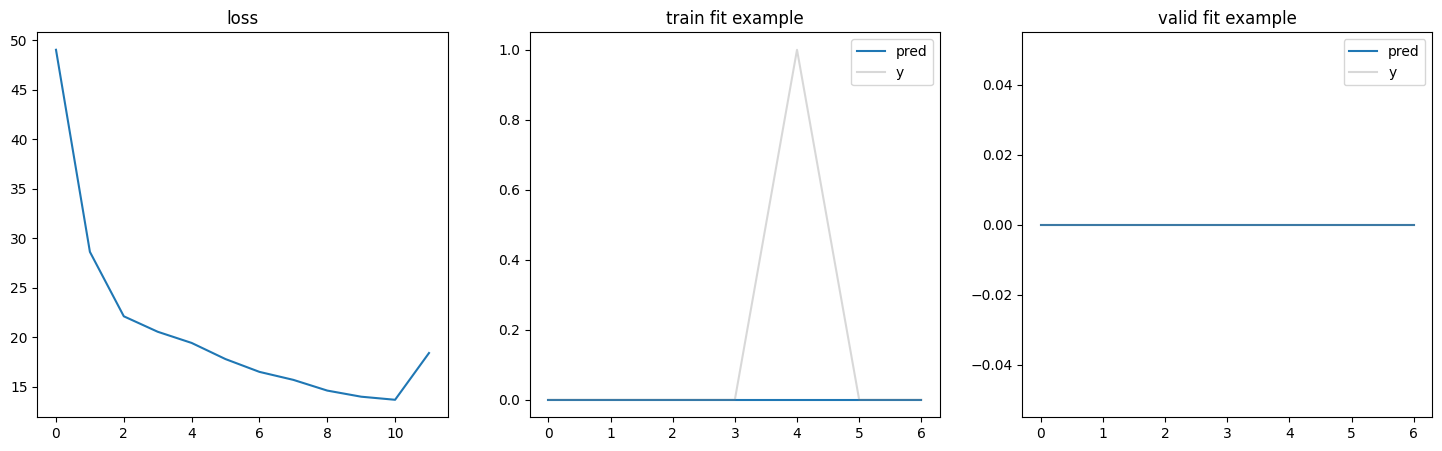

 train_loss: 18.409420530001324, valid_loss: 0.42565138762195903

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loss_li = []
temp = None

def train():
    global temp
    total_loss = 0
    total_val_loss = 0
    for n, (data, valid) in enumerate(zip(train_dataloader, valid_dataloader)):
        model.train(True)
        clear_output(wait=True)

        # Train
        optimizer.zero_grad()
        pred, y = model(data)
        temp = pred

        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)

        # Plot loss
        plt.figure(figsize=(18,5))
        plt.subplot(1,3,1)
        loss_li.append(mean_loss)
        plt.plot(loss_li)
        plt.title("loss")

        # Plot
        plt.subplot(1,3,2)
        loss = torch.nn.MSELoss(reduction="none")(pred, y)
        loss = loss.mean(axis=1)
        best_idx = loss.argmin()
        pred = torch.round(pred)
        pred[pred<0] = 0
        plt.plot(pred[-1].cpu().detach().numpy(), label="pred")
        plt.plot(y[-1].cpu().detach().numpy(), label="y", color="gray", alpha=0.3)
        plt.title("train fit example")
        plt.legend()

        # Plot valid prediction
        model.eval()
        pred, y = model(valid)
        val_loss = loss_fn(pred, y)

        total_val_loss += val_loss.item()
        mean_val_loss = total_val_loss / (n+1)

        val_loss = torch.nn.MSELoss(reduction="none")(pred, y)
        val_loss = val_loss.mean(axis=1)
        best_idx = val_loss.argmin()
        pred = torch.round(pred)
        pred[pred<0] = 0
        plt.subplot(1,3,3)
        plt.plot(pred[-1].cpu().detach().numpy(), label="pred")
        plt.plot(y[-1].cpu().detach().numpy(), label="y", color="gray", alpha=0.3)
        plt.title("valid fit example")
        plt.legend()
        plt.show()

        print(f"\r train_loss: {mean_loss}, valid_loss: {mean_val_loss}", end="")

    return mean_loss
            
for epoch in range(1):
    mean_train_loss = train()
